In [3]:
import logging as lg
from pathlib import Path
from keras.utils import to_categorical
from keras.datasets import mnist
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [4]:
verbose=True
BATCH_SIZE=100
VALID_RATE=0.1

RESULT_DIR=Path(f"result/multi_mnist_{BATCH_SIZE}_{VALID_RATE}")
if verbose:
    lg.getLogger().setLevel(lg.INFO)
    lg.info("Verbose mode activated")

INFO:root:Verbose mode activated


In [5]:
from tools.models import KerasRegressorInterface

In [6]:
from sklearn.model_selection import train_test_split
(x_train_val, y_train_val), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size=VALID_RATE)

In [7]:
from keras.preprocessing.image import ImageDataGenerator
class MultipleMnistGenerator:
    def __init__(self):
        self.img_gen= ImageDataGenerator(rescale=1./255)
         
    def flow(self,images,labels,batch_size=1):
        images=self.preprocess(images)
        img_g1=self.img_gen.flow(images,labels,batch_size=batch_size)
        img_g2=self.img_gen.flow(images,labels,batch_size=batch_size)
        while True:
            img1,label1=next(img_g1)
            img2,label2=next(img_g2)
            label=label1*label2         
            yield [img1,img2],label
            
    def preprocess(self,images):
        images=images.reshape(images.shape[0], 28,28,1)
        return images
    

In [8]:
from keras.utils import Sequence
import math

class MultipleMnistSequence(Sequence):
    def __init__(self,images,labels,batch_size):
        self.batch_size = batch_size
        images=self.preprocess(images)
        img_gen=ImageDataGenerator(rescale=1./255)
        self.img_g1=img_gen.flow(images,labels,batch_size=batch_size)
        self.img_g2=img_gen.flow(images,labels,batch_size=batch_size)
        self.samples=len(images)
        

    def __getitem__(self, idx):
        # バッチサイズ分取り出す
        img1,label1=next(self.img_g1)
        img2,label2=next(self.img_g2)
        label=label1*label2         
        return [img1, img2], label
    
    def __len__(self):
        return math.ceil(self.samples / self.batch_size)

    def preprocess(self, images):
        images=images.reshape(images.shape[0], 28,28,1)
        return images

In [9]:
gen=MultipleMnistSequence(X_train,y_train, BATCH_SIZE)
gen_val=MultipleMnistSequence(X_valid,y_valid, 1)

In [10]:
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D,concatenate
from keras.models import Model
class DoubleCnnRegressor(KerasRegressorInterface):

    def __init__(self, result_dir,input_height, input_width, input_channels, filters=64, kernel_size=(3, 3),
                 trained_epochs=0, batch_size=1, valid_rate=None, pool_size=(2, 2), med_dim=128,
                 dropout_rate=0.25, activation="relu",
                 loss="mean_squared_error", optimizer='rmsprop'):
        self.input_height = input_height
        self.input_width = input_width
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.filters = filters
        self.pool_size = pool_size
        self.med_dim = med_dim
        self.dropout_rate = dropout_rate
        self.activation = activation
        super().__init__(trained_epochs, result_dir, loss, optimizer)

    def construct(self):
        img_1 = Input(shape=(self.input_height, self.input_width, self.input_channels), name='img1')
       
        x = Conv2D(self.filters, self.kernel_size,activation=self.activation)(img_1)
        x = MaxPooling2D(pool_size=self.pool_size)(x)
        x = Dropout(self.dropout_rate)(x)
        x = Flatten()(x)
        med1 = Dense(self.med_dim, activation=self.activation)(x)
        
        img_2 = Input(shape=(self.input_height, self.input_width, self.input_channels), name='img2')
        y = Conv2D(self.filters, self.kernel_size,activation=self.activation)(img_2)
        y = MaxPooling2D(pool_size=self.pool_size)(y)
        y = Dropout(self.dropout_rate)(y)
        y = Flatten()(y)
        med2 = Dense(self.med_dim, activation=self.activation)(y)

        z = concatenate([med1, med2])
        z = Dense(self.med_dim, activation=self.activation)(z)
        predictions = Dense(1)(z)
        model = Model(inputs=[img_1,img_2], outputs=predictions)
        model.compile(optimizer=self.optimizer,loss=self.loss, metrics=self.metrics)
        
        return model

    def create_flag(self):
        return f"dcr_{self.input_height}_{self.input_width}_{self.input_channels}_{self.filters}_{self.pool_size}_{self.med_dim}_{self.dropout_rate}_{self.activation}"


In [11]:
model=DoubleCnnRegressor(RESULT_DIR,28,28,1,trained_epochs=20)

INFO:root:Loading the trained model...
INFO:root:Loaded.


In [12]:
model.fit_generator(gen,20,gen_val)

INFO:root:This model has already been traiend up to 20 epochs


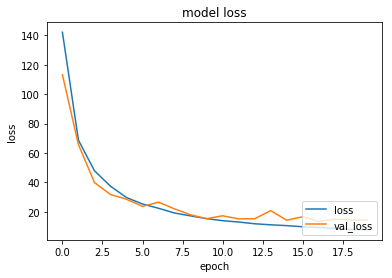

In [13]:
model.plot_history(20)